# Modèles Support Vector Machine (SVM) pour classification défaut de crédit

Ce notebook implémente les trois types de SVM pour la classification
1. **C-Support Vector Classification (C-SVC)** - SVM standard avec le paramètre C
3. **Linear SVM** - SVM Linéaire
4. **Non-linear SVM** - SVM avec l'astuce kernel (RBF kernel)
Each model will be trained, evaluated, and compared.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Contexte
1. Le dataset étudié est déséquilibré où 88% de variable cible et de classe 0 l'autre est de classe 1 où notre intérêt réside.
2. Dans un premier temps on va travailler uniquement avec les modèles SVM sans technique pour addresser le problème de déséquilibre de dataset

# Librairies imports

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# SVM models
from cuml.svm import SVC as cuSVC
import time
import cupy as cp
import cudf
from imblearn.over_sampling import SMOTE


# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Utilities
import time
import pickle
from imblearn.under_sampling import RandomUnderSampler


# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# Chargement de données

In [3]:
# Load the standardized dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_standardized.csv', index_col=0)

print("Dataset Shape:", data.shape)
print("\n" + "="*50)
print("First few rows:")
print(data.head())
print("\n" + "="*50)
print("Dataset Info:")
print(data.info())

Dataset Shape: (255347, 6)

First few rows:
        Age    Income  LoanAmount  MonthsEmployed  InterestRate  Default
0  0.833990  0.089693   -1.086833        0.590533      0.261771        0
1  1.701221 -0.823021   -0.044309       -1.285731     -1.308350        0
2  0.166888  0.043854    0.022715       -0.968209      1.156831        1
3 -0.767053 -1.303452   -1.168538       -1.718715     -0.967805        0
4  1.100830 -1.592855   -1.671921       -1.487790     -1.052188        0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 255347 entries, 0 to 255346
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  float64
 1   Income          255347 non-null  float64
 2   LoanAmount      255347 non-null  float64
 3   MonthsEmployed  255347 non-null  float64
 4   InterestRate    255347 non-null  float64
 5   Default         255347 non-null  int64  
dtypes: float64(5), int64(1)
m

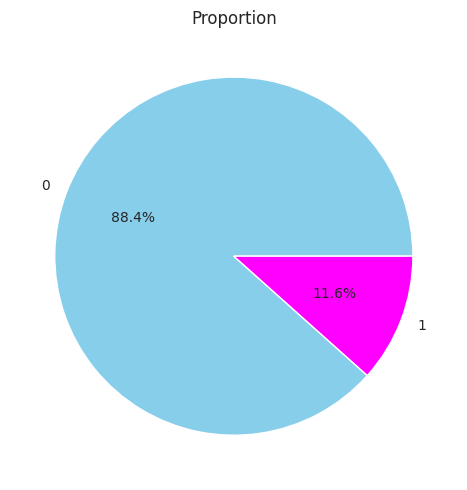

In [4]:
plt.figure(figsize=(5, 5))
data['Default'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                    colors=['skyblue', 'magenta'])
plt.title('Proportion')
plt.ylabel('')  # Remove the ylabel for cleaner appearance
plt.tight_layout()
plt.show()

# Techniques de rééquilibre utilisé:
1. sans technique
2. Ajustement du poids de la classe
3. SMOTE

# Split data and prepare it for GPU calculation

In [5]:
# Separate features and target variable
X = data.drop('Default', axis=1)
y = data['Default']

# Ensure proper data types to avoid attribute errors
X = X.astype('float64')
y = y.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Convert now GPU
X_train_gpu = cp.asarray(X_train)
y_train_gpu = cp.asarray(y_train)
X_test_gpu = cp.asarray(X_test)

## Model 1: SVM non linéaire Kernal astuce


In [6]:
start_time = time.time()

# Create a cuSVC model
c_svc = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=True
)

# Fit the model on GPU
c_svc.fit(X_train_gpu, y_train_gpu)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")

✓ Training completed in 556.77 seconds on GPU!


In [7]:
y_pred_gpu = c_svc.predict(X_test_gpu)
y_pred = cp.asnumpy(y_pred_gpu).astype('int64')

# Manual probability via decision function + sigmoid
decision = c_svc.decision_function(X_test_gpu)
decision_np = cp.asnumpy(decision)
y_prob = 1 / (1 + np.exp(-decision_np))

# Keep test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred.shape}")
print(f"Probability range: [{y_prob.min():.4f}, {y_prob.max():.4f}]")

Test predictions shape: (51070,)
Probability range: [0.2561, 0.8379]



 EVALUATION RESULTS: C support vector machine

Classification Report:
              precision    recall  f1-score   support

           0     0.8863    0.9981    0.9389     45139
           1     0.6398    0.0255    0.0490      5931

    accuracy                         0.8852     51070
   macro avg     0.7631    0.5118    0.4939     51070
weighted avg     0.8577    0.8852    0.8355     51070


ROC-AUC Score       : 0.5779
PR-AUC (Avg Precision) : 0.2326
Class 1 F1-Score    : 0.0490
Class 1 Recall      : 0.0255
Class 1 Precision   : 0.6398

Confusion Matrix:
[[45054    85]
 [ 5780   151]]


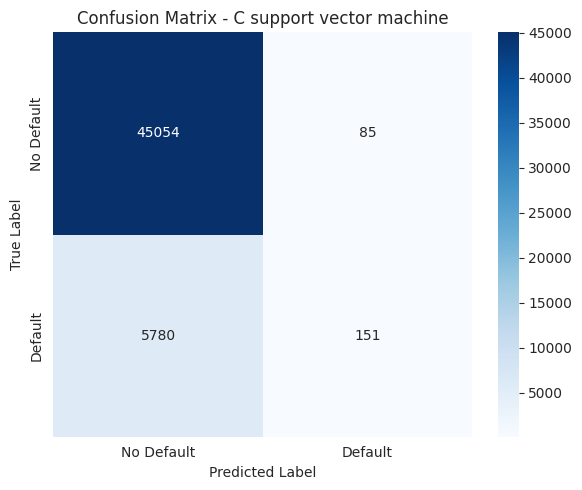

In [8]:
def evaluate_model_final(y_true, y_pred, y_prob, model_name):
    print("\n" + "="*60)
    print(f" EVALUATION RESULTS: {model_name}")
    print("="*60)

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    print(classification_report(y_true, y_pred, digits=4))

    # Key Metrics
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    print(f"\nROC-AUC Score       : {roc_auc:.4f}")
    print(f"PR-AUC (Avg Precision) : {pr_auc:.4f}")

    # Extract F1 for class 1
    f1_class1 = report['1']['f1-score']
    recall_class1 = report['1']['recall']
    precision_class1 = report['1']['precision']
    print(f"Class 1 F1-Score    : {f1_class1:.4f}")
    print(f"Class 1 Recall      : {recall_class1:.4f}")
    print(f"Class 1 Precision   : {precision_class1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
#evaluation
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred,
    y_prob=y_prob,
    model_name="C support vector machine"
)

# Modèle 2 : Linear SVM (Linear Kernel)

In [9]:
start_time = time.time()

# Use GPU-accelerated Linear SVC from cuML
linear_svm = cuSVC(
    kernel='linear',
    C=1.0,
    probability=True
)
# Fit the model on GPU
linear_svm.fit(X_train_gpu, y_train_gpu)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")


[2025-11-06 15:20:30.213] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
✓ Training completed in 29.05 seconds on GPU!


Test predictions shape: (51070,)
Probability range: [0.2689, 0.2690]

 EVALUATION RESULTS: Linear Kernel

Classification Report:
              precision    recall  f1-score   support

           0     0.8839    1.0000    0.9384     45139
           1     0.0000    0.0000    0.0000      5931

    accuracy                         0.8839     51070
   macro avg     0.4419    0.5000    0.4692     51070
weighted avg     0.7812    0.8839    0.8294     51070


ROC-AUC Score       : 0.5002
PR-AUC (Avg Precision) : 0.1196
Class 1 F1-Score    : 0.0000
Class 1 Recall      : 0.0000
Class 1 Precision   : 0.0000

Confusion Matrix:
[[45139     0]
 [ 5931     0]]


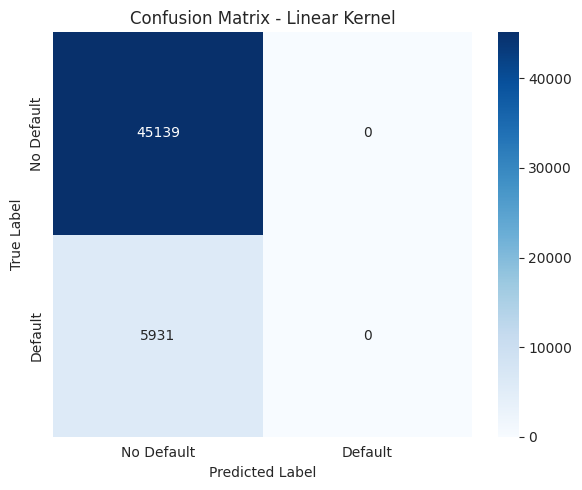

In [10]:
y_pred_gpu_2 = linear_svm.predict(X_test_gpu)
y_pred_2 = cp.asnumpy(y_pred_gpu_2).astype('int64')

# Manual probability via decision function + sigmoid
decision_2 = linear_svm.decision_function(X_test_gpu)
decision_np_2 = cp.asnumpy(decision_2)
y_prob_2 = 1 / (1 + np.exp(-decision_np_2))

# Keep test labels as numpy
y_test_np_2 = y_test.copy()

print(f"Test predictions shape: {y_pred_2.shape}")
print(f"Probability range: [{y_prob_2.min():.4f}, {y_prob_2.max():.4f}]")
evaluate_model_final(
    y_true=y_test_np_2,
    y_pred=y_pred_2,
    y_prob=y_prob_2,
    model_name="Linear Kernel"
)

## Modèle 3: SVM polynomiale

In [11]:
start_time = time.time()
poly_svm = cuSVC(
    C=1.0,
    kernel='poly',
    degree=3,      # You can change this to 2, 4, 5, etc.
    gamma='scale',
    coef0=1.0,
    probability=True
)

# Fit model on GPU
poly_svm.fit(X_train_gpu, y_train_gpu)

# Predictions (on GPU → then convert to CPU)
y_pred_poly_gpu = poly_svm.predict(X_test_gpu)
y_pred_poly = cp.asnumpy(y_pred_poly_gpu).astype('int64')

# Decision scores → convert to pseudo-probability using sigmoid
decision_poly = poly_svm.decision_function(X_test_gpu)
decision_poly_np = cp.asnumpy(decision_poly)
y_prob_poly = 1 / (1 + np.exp(-decision_poly_np))

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")

✓ Training completed in 109.31 seconds on GPU!



 EVALUATION RESULTS: Polynomial Kernel (Degree=3)

Classification Report:
              precision    recall  f1-score   support

           0     0.8839    1.0000    0.9384     45139
           1     0.0000    0.0000    0.0000      5931

    accuracy                         0.8839     51070
   macro avg     0.4419    0.5000    0.4692     51070
weighted avg     0.7812    0.8839    0.8294     51070


ROC-AUC Score       : 0.6395
PR-AUC (Avg Precision) : 0.2052
Class 1 F1-Score    : 0.0000
Class 1 Recall      : 0.0000
Class 1 Precision   : 0.0000

Confusion Matrix:
[[45139     0]
 [ 5931     0]]


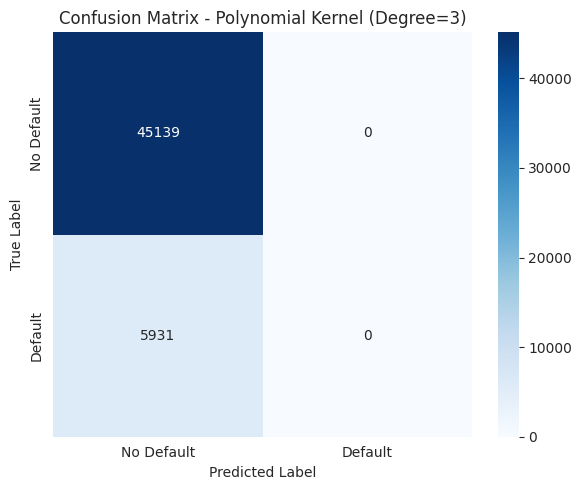

In [12]:
evaluate_model_final(
    y_true=y_test,          # or y_test_np_2 if that’s what you used
    y_pred=y_pred_poly,
    y_prob=y_prob_poly,
    model_name="Polynomial Kernel (Degree=3)"
)


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features scaled: X_train {X_train.shape} → scaled")

# --------------------------------------------------
# 2. Fit PCA on training data (2 components)
# --------------------------------------------------
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_scaled)

# Transform test set
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA completed: {X_test_pca.shape[1]} components")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")
pca_df = pd.DataFrame({
    'PC1': X_test_pca[:, 0],
    'PC2': X_test_pca[:, 1],
    'Default': y_test.astype(int)
})

print(f"PCA DataFrame ready: {pca_df.shape}")
print("Class distribution in test set:")
print(pca_df['Default'].value_counts())

Features scaled: X_train (204277, 5) → scaled
PCA completed: 2 components
Explained variance ratio: [0.2010752  0.20068059]
Total variance explained: 0.402
PCA DataFrame ready: (51070, 3)
Class distribution in test set:
Default
0    45139
1     5931
Name: count, dtype: int64


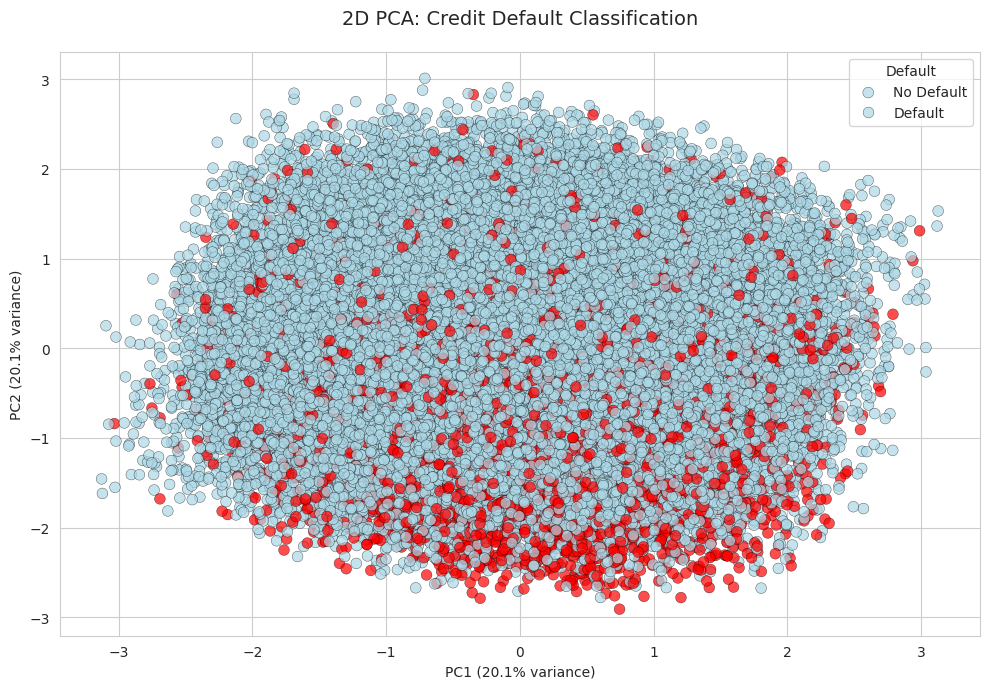

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Scatter plot
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Default',
    palette={0: 'lightblue', 1: 'red'},
    alpha=0.7,
    s=60,
    edgecolor='k',
    linewidth=0.3
)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('2D PCA: Credit Default Classification', fontsize=14, pad=20)
plt.legend(title='Default', labels=['No Default', 'Default'])

# Optional: Add density contours
# sns.kdeplot(data=pca_df[pca_df['Default']==1], x='PC1', y='PC2', levels=5, color="red", linewidths=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Conclusion: pour le momoent le SVM non linéaire classifier a les bons résultats entre les 3 modèle

## 2. Les modèles avec justement du poids de la classe

# Modèle non linéaire avec ajustement de poids

In [16]:
start_time=time.time()

c_svc_weighted = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=False,
    class_weight='balanced'
)

c_svc_weighted.fit(X_train_gpu, y_train_gpu)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")



✓ Training completed in 38.93 seconds on GPU!



 EVALUATION RESULTS: RBF Kernel (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.9430    0.6818    0.7914     45139
           1     0.2208    0.6864    0.3342      5931

    accuracy                         0.6823     51070
   macro avg     0.5819    0.6841    0.5628     51070
weighted avg     0.8591    0.6823    0.7383     51070


ROC-AUC Score       : 0.7378
PR-AUC (Avg Precision) : 0.2770
Class 1 F1-Score    : 0.3342
Class 1 Recall      : 0.6864
Class 1 Precision   : 0.2208

Confusion Matrix:
[[30775 14364]
 [ 1860  4071]]


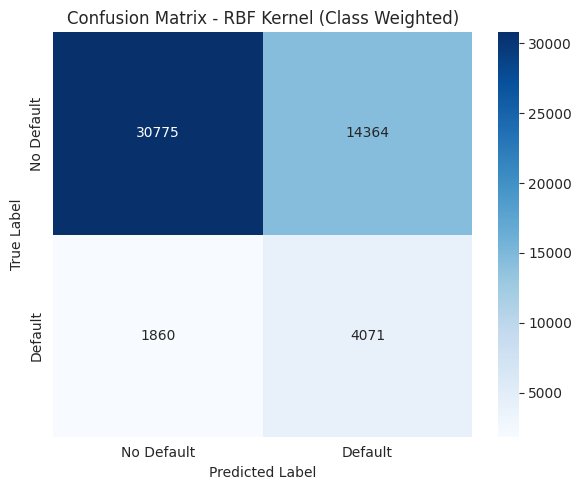

In [17]:
y_pred_weighted_gpu = c_svc_weighted.predict(X_test_gpu)
y_pred_weighted = cp.asnumpy(y_pred_weighted_gpu).astype('int64')

# ✅ 3. Get decision function → convert to probability-like score manually
decision_weighted = c_svc_weighted.decision_function(X_test_gpu)
decision_weighted_np = cp.asnumpy(decision_weighted)

# Apply sigmoid manually to map decision scores → [0, 1]
y_prob_weighted = 1 / (1 + np.exp(-decision_weighted_np))

# ✅ 4. Evaluate model
evaluate_model_final(
    y_true=y_test,               # or y_test_np if used earlier
    y_pred=y_pred_weighted,
    y_prob=y_prob_weighted,
    model_name="RBF Kernel (Class Weighted)"
)

## Modèle linéaire avec ajustement du poids de la classe

In [18]:
linear_svc_weighted_gpu = cuSVC(
    C=1.0,
    kernel='linear',
    class_weight='balanced',
    probability=False
)

# Train
linear_svc_weighted_gpu.fit(X_train_gpu, y_train_gpu)

# Predict (labels)
y_pred_linear_gpu = linear_svc_weighted_gpu.predict(X_test_gpu)
y_pred_linear_gpu = cp.asnumpy(y_pred_linear_gpu).astype('int64')

# Decision function → convert to probability-like values using sigmoid
decision_linear = linear_svc_weighted_gpu.decision_function(X_test_gpu)
decision_linear_np = cp.asnumpy(decision_linear)
y_prob_linear_gpu = 1 / (1 + np.exp(-decision_linear_np))


 EVALUATION RESULTS: Linear SVM (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.9435    0.6579    0.7753     45139
           1     0.2120    0.7002    0.3254      5931

    accuracy                         0.6628     51070
   macro avg     0.5777    0.6791    0.5503     51070
weighted avg     0.8586    0.6628    0.7230     51070


ROC-AUC Score       : 0.7393
PR-AUC (Avg Precision) : 0.2881
Class 1 F1-Score    : 0.3254
Class 1 Recall      : 0.7002
Class 1 Precision   : 0.2120

Confusion Matrix:
[[29698 15441]
 [ 1778  4153]]


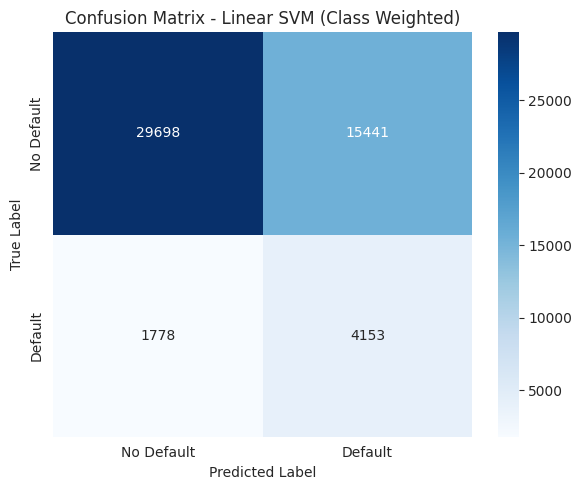

In [19]:
evaluate_model_final(
    y_true=y_test,
    y_pred=y_pred_linear_gpu,
    y_prob=y_prob_linear_gpu,
    model_name="Linear SVM (Class Weighted)"
)

# Modèle non linéaire avec SMOTE

In [20]:
X_train_cpu = X_train.copy()
y_train_cpu = y_train.copy()

print(f"Original train shape: {X_train_cpu.shape}")
print(f"Class distribution before SMOTE:\n{pd.Series(y_train_cpu).value_counts()}")

# --------------------------------------------------
# 2. Apply SMOTE
# --------------------------------------------------
smote = SMOTE(random_state=42)
X_res_cpu, y_res_cpu = smote.fit_resample(X_train_cpu, y_train_cpu)

print(f"\nAfter SMOTE:")
print(f"Resampled train shape: {X_res_cpu.shape}")
print(f"Class distribution after SMOTE:\n{pd.Series(y_res_cpu).value_counts()}")

# --------------------------------------------------
# 3. Move back to GPU
# --------------------------------------------------
X_res = cp.asarray(X_res_cpu)
y_res = cp.asarray(y_res_cpu)
X_test_gpu = cp.asarray(X_test)

Original train shape: (204277, 5)
Class distribution before SMOTE:
Default
0    180555
1     23722
Name: count, dtype: int64

After SMOTE:
Resampled train shape: (361110, 5)
Class distribution after SMOTE:
Default
0    180555
1    180555
Name: count, dtype: int64


In [21]:


# Use GPU-accelerated SVC from cuML
c_svc = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',     # ← This is allowed
    probability=True,
    random_state=42
)

# Fit the model on GPU
c_svc.fit(X_res, y_res)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")

# Evaluate the model


[2025-11-06 15:32:55.704] [CUML] [warning] Random state is currently ignored by probabilistic SVC
✓ Training completed in 713.66 seconds on GPU!


Test predictions shape: (51070,)
Probability range: [0.1415, 0.8407]

 EVALUATION RESULTS: cuSVC (SMOTE )

Classification Report:
              precision    recall  f1-score   support

           0     0.9430    0.6792    0.7897     45139
           1     0.2198    0.6877    0.3331      5931

    accuracy                         0.6802     51070
   macro avg     0.5814    0.6835    0.5614     51070
weighted avg     0.8590    0.6802    0.7366     51070


ROC-AUC Score       : 0.7366
PR-AUC (Avg Precision) : 0.2740
Class 1 F1-Score    : 0.3331
Class 1 Recall      : 0.6877
Class 1 Precision   : 0.2198

Confusion Matrix:
[[30659 14480]
 [ 1852  4079]]


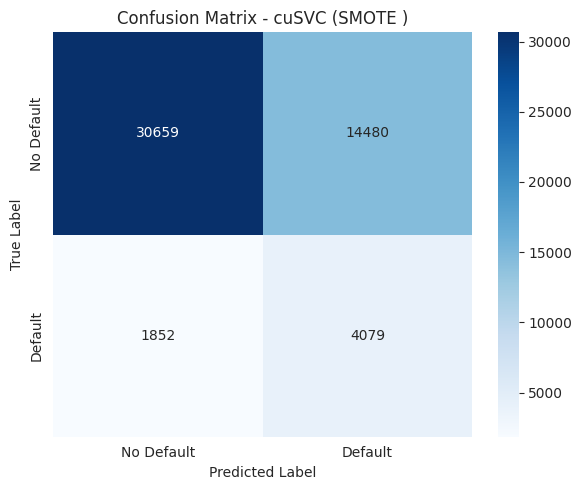

In [22]:
y_pred_gpu_smote = c_svc.predict(X_test_gpu)
y_pred_smote = cp.asnumpy(y_pred_gpu_smote).astype('int64')

# Manual probability via decision function + sigmoid
decision_smote = c_svc.decision_function(X_test_gpu)
decision_np_smote = cp.asnumpy(decision_smote)
y_prob_smote = 1 / (1 + np.exp(-decision_np_smote))

# Keep test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred_smote.shape}")
print(f"Probability range: [{y_prob_smote.min():.4f}, {y_prob_smote.max():.4f}]")
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_smote,
    y_prob=y_prob_smote,
    model_name="cuSVC (SMOTE )"
)

In [24]:
start_time = time.time()

# Define Linear SVM with class weights
linear_svc_gpu = cuSVC(
    C=1.0,                # Regularization parameter
    kernel='linear',       # Linear SVM,  # Handle class imbalance
    probability=True      # Faster training; we'll compute pseudo-probabilities manuall
)
linear_svc_gpu.fit(X_res, y_res)
training_time = time.time() - start_time
print(f"✓ Linear SVM training completed in {training_time:.2f} seconds on GPU!")

✓ Linear SVM training completed in 429.65 seconds on GPU!


In [25]:
# Convert test data to GPU
X_test_gpu = cp.asarray(X_test)

# Predict labels
y_pred_linear_gpu = linear_svc_gpu.predict(X_test_gpu)
y_pred_linear = cp.asnumpy(y_pred_linear_gpu).astype('int64')

# Decision function → pseudo-probabilities
decision_linear = linear_svc_gpu.decision_function(X_test_gpu)
decision_linear_np = cp.asnumpy(decision_linear)
y_prob_linear = 1 / (1 + np.exp(-decision_linear_np))  # sigmoid for probability-like values

# Test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred_linear.shape}")
print(f"Probability range: [{y_prob_linear.min():.4f}, {y_prob_linear.max():.4f}]")


Test predictions shape: (51070,)
Probability range: [0.0304, 0.9426]



 EVALUATION RESULTS: Linear SVM (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.9431    0.6618    0.7778     45139
           1     0.2129    0.6962    0.3261      5931

    accuracy                         0.6658     51070
   macro avg     0.5780    0.6790    0.5519     51070
weighted avg     0.8583    0.6658    0.7253     51070


ROC-AUC Score       : 0.7393
PR-AUC (Avg Precision) : 0.2878
Class 1 F1-Score    : 0.3261
Class 1 Recall      : 0.6962
Class 1 Precision   : 0.2129

Confusion Matrix:
[[29873 15266]
 [ 1802  4129]]


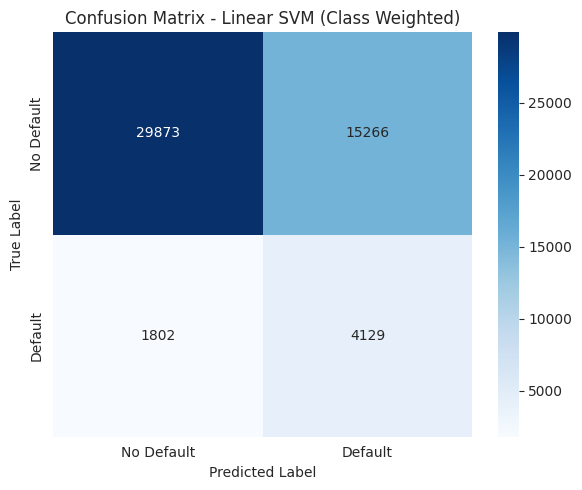

In [26]:
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_linear,
    y_prob=y_prob_linear,
    model_name="Linear SVM (Class Weighted)"
)


# Modèles avec sous-échantillonage

1. Modèle linéaire SVM avec sous-échantillonage


In [27]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res_under, y_res_under = rus.fit_resample(X_train, y_train)

print("Before Under-sampling:", y_train.value_counts(normalize=True) * 100)
print("After Under-sampling:", pd.Series(y_res_under).value_counts(normalize=True) * 100)

# Convert to GPU
X_res_under_gpu = cp.asarray(X_res_under, dtype='float64')
y_res_under_gpu = cp.asarray(y_res_under, dtype='int64')

Before Under-sampling: Default
0    88.387337
1    11.612663
Name: proportion, dtype: float64
After Under-sampling: Default
0    50.0
1    50.0
Name: proportion, dtype: float64


In [28]:
import time
from cuml.svm import SVC as cuSVC

# Linear SVM
start_time = time.time()
linear_svc_under = cuSVC(
    C=1.0,
    kernel='linear',
    probability=False,
    class_weight=None  # No need, data is balanced now
)

linear_svc_under.fit(X_res_under_gpu, y_res_under_gpu)
print(f"✓ Linear SVM trained in {time.time() - start_time:.2f} seconds")


✓ Linear SVM trained in 7.58 seconds


In [29]:
# Prediction
y_pred_linear_gpu = linear_svc_under.predict(X_test_gpu)
y_pred_linear = cp.asnumpy(y_pred_linear_gpu)

# Convert decision_function → probability-like score
decision_linear = linear_svc_under.decision_function(X_test_gpu)
decision_linear_np = cp.asnumpy(decision_linear)
y_prob_linear = 1 / (1 + np.exp(-decision_linear_np))  # Sigmoid



 EVALUATION RESULTS: Linear SVM (Under-sampled)

Classification Report:
              precision    recall  f1-score   support

           0     0.9432    0.6593    0.7761     45139
           1     0.2121    0.6979    0.3253      5931

    accuracy                         0.6638     51070
   macro avg     0.5776    0.6786    0.5507     51070
weighted avg     0.8583    0.6638    0.7237     51070


ROC-AUC Score       : 0.7394
PR-AUC (Avg Precision) : 0.2881
Class 1 F1-Score    : 0.3253
Class 1 Recall      : 0.6979
Class 1 Precision   : 0.2121

Confusion Matrix:
[[29760 15379]
 [ 1792  4139]]


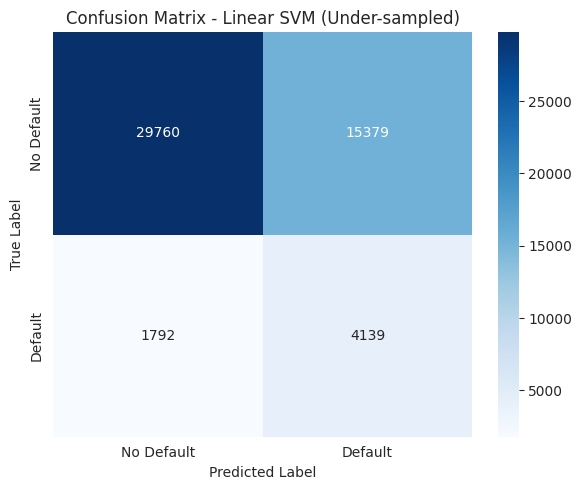

In [30]:
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_linear,
    y_prob=y_prob_linear,
    model_name="Linear SVM (Under-sampled)"
)


2. Modèle SVM non linéaire avec sous-échantillonage

In [31]:
# RBF SVM
start_time = time.time()
rbf_svc_under = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=False,  # Manual probability from decision function
    class_weight=None
)

rbf_svc_under.fit(X_res_under_gpu, y_res_under_gpu)
print(f"✓ RBF SVM trained in {time.time() - start_time:.2f} seconds")


✓ RBF SVM trained in 3.26 seconds



 EVALUATION RESULTS: RBF SVM (Under-sampled)

Classification Report:
              precision    recall  f1-score   support

           0     0.9434    0.6777    0.7888     45139
           1     0.2197    0.6906    0.3334      5931

    accuracy                         0.6792     51070
   macro avg     0.5816    0.6842    0.5611     51070
weighted avg     0.8594    0.6792    0.7359     51070


ROC-AUC Score       : 0.7386
PR-AUC (Avg Precision) : 0.2783
Class 1 F1-Score    : 0.3334
Class 1 Recall      : 0.6906
Class 1 Precision   : 0.2197

Confusion Matrix:
[[30592 14547]
 [ 1835  4096]]


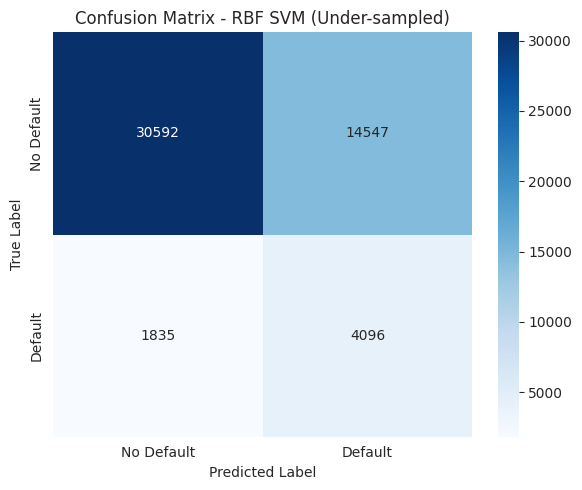

In [32]:
# Prediction
y_pred_rbf_gpu = rbf_svc_under.predict(X_test_gpu)
y_pred_rbf = cp.asnumpy(y_pred_rbf_gpu)

# Decision function → probability-like values
decision_rbf = rbf_svc_under.decision_function(X_test_gpu)
decision_rbf_np = cp.asnumpy(decision_rbf)
y_prob_rbf = 1 / (1 + np.exp(-decision_rbf_np))

# Evaluation
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_rbf,
    y_prob=y_prob_rbf,
    model_name="RBF SVM (Under-sampled)"
)


# Model Comparison and Best Model Selection

In [ ]:
# Store all model results for comparison (F1-Score and Recall only)
models_comparison = []

# Helper function to safely convert to numpy
def to_numpy(arr):
    if hasattr(arr, '__cuda_array_interface__'):
        return arr.get()
    # If it's already a numpy array or pandas series, convert to numpy
    elif hasattr(arr, 'to_numpy'):
        return arr.to_numpy()
    elif hasattr(arr, 'values'):
        return arr.values
    return arr

def add_model_metrics(model_name, model_obj, y_true, y_pred):
    y_true_safe = to_numpy(y_true)
    y_pred_safe = to_numpy(y_pred)
    report = classification_report(y_true_safe, y_pred_safe, digits=4, output_dict=True)
    models_comparison.append({
        'Model Name': model_name,
        'Model Object': model_obj,
        'F1-Score (Class 1)': report['1']['f1-score'],
        'Recall (Class 1)': report['1']['recall']
    })

# Model 1: C-SVC (RBF, No Balancing)
add_model_metrics('C-SVC (RBF, No Balancing)', c_svc, y_test_np, y_pred)

# Model 2: Linear SVM (No Balancing)
add_model_metrics('Linear SVM (No Balancing)', linear_svm, y_test_np_2, y_pred_2)

# Model 3: Polynomial SVM
add_model_metrics('Polynomial SVM (Degree=3)', poly_svm, y_test, y_pred_poly)

# Model 4: RBF with class weights
add_model_metrics('RBF SVM (Class Weighted)', c_svc_weighted, y_test, y_pred_weighted)

# Model 5: Linear SVM with class weights
add_model_metrics('Linear SVM (Class Weighted)', linear_svc_weighted_gpu, y_test, y_pred_linear_gpu)

# Model 6: RBF with SMOTE
add_model_metrics('RBF SVM (SMOTE)', c_svc, y_test_np, y_pred_smote)

# Model 7: Linear SVM with SMOTE
add_model_metrics('Linear SVM (SMOTE)', linear_svc_gpu, y_test_np, y_pred_linear)

# Model 8: Linear SVM with under-sampling
add_model_metrics('Linear SVM (Under-sampled)', linear_svc_under, y_test_np, y_pred_linear)

# Model 9: RBF SVM with under-sampling
add_model_metrics('RBF SVM (Under-sampled)', rbf_svc_under, y_test_np, y_pred_rbf)

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_comparison).drop('Model Object', axis=1)

print("="*60)
print(" MODEL COMPARISON: F1-SCORE & RECALL (Class 1)")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

In [ ]:
# Visualize F1-Score and Recall comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Performance Comparison: F1-Score & Recall (Class 1)', fontsize=14, fontweight='bold')

model_names = [model['Model Name'] for model in models_comparison]

# Plot 1: F1-Score
axes[0].barh(model_names, [model['F1-Score (Class 1)'] for model in models_comparison], color='steelblue')
axes[0].set_xlabel('F1-Score (Class 1)', fontsize=11)
axes[0].set_title('F1-Score Comparison', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Recall
axes[1].barh(model_names, [model['Recall (Class 1)'] for model in models_comparison], color='coral')
axes[1].set_xlabel('Recall (Class 1)', fontsize=11)
axes[1].set_title('Recall Comparison', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Select best model based on F1-Score and Recall
print("\n" + "="*60)
print(" BEST MODEL SELECTION")
print("="*60)

# Calculate composite score (50% F1-Score, 50% Recall)
for model in models_comparison:
    model['Composite Score'] = (model['F1-Score (Class 1)'] * 0.5 + 
                                 model['Recall (Class 1)'] * 0.5)

# Find best model
best_model_idx = max(range(len(models_comparison)), key=lambda i: models_comparison[i]['Composite Score'])
best_model = models_comparison[best_model_idx]

# Display ranked models
comparison_ranked = pd.DataFrame(models_comparison).drop('Model Object', axis=1)
comparison_ranked = comparison_ranked.sort_values('Composite Score', ascending=False)

print("\n" + "="*60)
print(" ALL MODELS RANKED BY COMPOSITE SCORE")
print("="*60)
print(comparison_ranked.to_string(index=False))
print("="*60)

print("\n" + "="*60)
print(" BEST MODEL")
print("="*60)
print(f"Model Name:          {best_model['Model Name']}")
print(f"Composite Score:     {best_model['Composite Score']:.4f}")
print(f"F1-Score (Class 1):  {best_model['F1-Score (Class 1)']:.4f}")
print(f"Recall (Class 1):    {best_model['Recall (Class 1)']:.4f}")
print("="*60)

In [ ]:
# Save the best model - Modified for Colab
import pickle
import os

# Create Models directory in current location (/content/)
models_dir = './Models'
os.makedirs(models_dir, exist_ok=True)

# Save the best model
best_model_object = best_model['Model Object']
best_model_name = best_model['Model Name'].replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
model_filename = f'{models_dir}/best_svm_model_{best_model_name}.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(best_model_object, f)

# Save metadata and summary (same as before)
metadata = {
    'model_name': best_model['Model Name'],
    'composite_score': best_model['Composite Score'],
    'f1_score': best_model['F1-Score (Class 1)'],
    'recall': best_model['Recall (Class 1)'],
    'saved_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_filename = f'{models_dir}/best_svm_model_metadata.pkl'
with open(metadata_filename, 'wb') as f:
    pickle.dump(metadata, f)

# Save summary report
summary_filename = f'{models_dir}/model_comparison_summary.txt'
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write(" SVM MODELS COMPARISON (F1-Score & Recall)\n")
    f.write("="*60 + "\n\n")
    f.write(comparison_ranked.to_string(index=False))
    f.write("\n\n" + "="*60 + "\n")
    f.write(" BEST MODEL\n")
    f.write("="*60 + "\n")
    f.write(f"Model Name:          {best_model['Model Name']}\n")
    f.write(f"Composite Score:     {best_model['Composite Score']:.4f}\n")
    f.write(f"F1-Score (Class 1):  {best_model['F1-Score (Class 1)']:.4f}\n")
    f.write(f"Recall (Class 1):    {best_model['Recall (Class 1)']:.4f}\n")
    f.write(f"Saved Date:          {metadata['saved_date']}\n")
    f.write("="*60 + "\n")

print("\n" + "="*60)
print(" FILES SAVED SUCCESSFULLY")
print("="*60)
print(f"Model:    {model_filename}")
print(f"Metadata: {metadata_filename}")
print(f"Summary:  {summary_filename}")
print("="*60)

# Show where files are actually saved
print(f"\nAbsolute paths:")
print(f"Models directory: {os.path.abspath(models_dir)}")

In [ ]:
from google.colab import files

# Download all model files
files.download(model_filename)
files.download(metadata_filename) 
files.download(summary_filename)